In [1]:
# !pip install opencv-python
# !pip install --upgrade pandas
# !pip install --upgrade scipy==1.0.0
# !pip install --upgrade matplotlib==2.1.2
# !pip install --upgrade pyarrow==0.8.0
# ! pip install --upgrade bcolz
# %cd fastai
# !python setup.py install
# !wget http://files.fast.ai/models/weights.tgz /output/weights.tgz
# !tar -xvzf /output/weights.tgz -C /usr/local/lib/python3.6/site-packages/fastai-0.6-py3.6.egg/fastai/ 
# %cp -r /prev_output/data /output/data

In [2]:
!ls /prev_output

Untitled.ipynb	data  fastai  run_cpu.sh  weights.tgz


In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *


In [6]:
PATH = "/data/"
arch=resnext101_64
sz=224
bs = 64

In [9]:
!ls {PATH}

labels.csv  raw  sample  sample_submission.csv	test


In [10]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH+'raw', tfms=tfms_from_model(arch, sz), trn_name='trn', test_name=PATH+'test/test_raw')


In [11]:
len(data.trn_ds), len(data.test_ds)

(9403, 10357)

In [12]:
len(data.classes), data.classes[:5]

(120,
 ['affenpinscher',
  'afghan_hound',
  'african_hunting_dog',
  'airedale',
  'american_staffordshire_terrier'])

In [13]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_paths(PATH+'raw', tfms=tfms_from_model(arch, sz), trn_name='trn', test_name=PATH+'test/test_raw')
    return data if sz>300 else data.resize(340, 'tmp')

In [14]:
data = get_data(sz, bs)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [16]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 162/162 [01:06<00:00,  2.44it/s]


In [14]:
# learn.load('/prev_output/244_pre')

In [17]:
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 94%|█████████▍| 138/147 [00:01<00:00, 81.50it/s, loss=10.9]


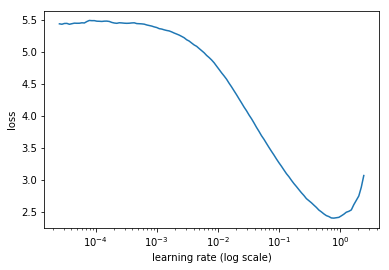

In [18]:
learn.sched.plot()


In [19]:
learn.fit(0.05, 5)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.5715     0.274657   0.915818  
    1      0.298673   0.235747   0.928144                    
    2      0.220193   0.243786   0.933258                    
    3      0.177294   0.24358    0.930854                    
    4      0.129071   0.270133   0.933564                    



[0.2701326, 0.933564291550563]

In [20]:
learn.precompute=False
learn.fit(1e-2, 5, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=31), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.081878   0.234165   0.935968  
    1      0.068828   0.231629   0.938066                     
    2      0.066138   0.227906   0.939268                     
    3      0.066659   0.22902    0.938066                     
    4      0.061163   0.222529   0.940776                     
    5      0.052993   0.225159   0.939574                     
    6      0.052571   0.223788   0.939574                     
    7      0.052961   0.232441   0.936864                     
    8      0.048514   0.233783   0.933258                     
    9      0.047105   0.230969   0.93446                      
    10     0.045492   0.22896    0.93446                      
    11     0.041635   0.228863   0.935662                     
    12     0.039875   0.226706   0.935662                     
  1%|          | 1/147 [00:00<01:48,  1.34it/s, loss=0.0408]

KeyboardInterrupt: 

In [22]:
learn.save('224_pre')

In [23]:
learn.set_data(get_data(299, bs))

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [24]:
learn.freeze()

In [25]:
learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

  2%|▏         | 3/147 [00:02<01:58,  1.22it/s, loss=0.0686]


Exception in thread Thread-20:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/local/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                     
    0      0.094423   0.234329   0.941978  
    1      0.08479    0.232377   0.94589                      
    2      0.080131   0.229847   0.945584                     



[0.22984664, 0.9455835223197937]

In [26]:
learn.fit(1e-3, 3, cycle_len=1, cycle_mult=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.079064   0.230715   0.946785  
    1      0.074861   0.228531   0.947987                     
    2      0.069995   0.228157   0.950391                     



[0.22815657, 0.950391214627486]

In [27]:
log_preds, y = learn.TTA(is_test=True)

In [28]:
probs = np.exp(log_preds)

In [29]:
probs.shape

(5, 10357, 120)

In [30]:
probs_sub = np.mean(probs, axis=0)

In [31]:
probs_sub.shape

(10357, 120)

In [32]:
ds = pd.DataFrame(probs_sub)
ds.columns = data.classes

In [33]:
ds.insert(0, 'id', [o[17:-4] for o in data.test_ds.fnames])

In [34]:
ds.head()


,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,d1f13576b39120c7e739218769191594,4.962077e-10,7.621493e-10,2.081721e-10,1.628483e-10,2.737312e-09,9.561179e-12,3.802745e-09,1.673607e-10,1.824227e-07,...,5.681234e-09,3.818471e-10,1.566059e-08,2.753769e-10,8.648930e-09,1.371892e-07,6.778130e-09,9.530336e-12,3.196703e-09,2.227682e-09
1,add5d56a7c6f2691ae9df6e79851d404,1.768872e-06,8.129727e-08,4.005889e-08,8.592405e-08,2.998990e-05,1.622967e-05,8.322598e-08,1.301815e-06,1.949856e-07,...,9.893830e-09,1.315412e-05,1.691609e-08,3.677014e-08,1.296954e-06,1.284554e-07,3.658409e-06,4.899474e-07,5.566604e-08,4.277305e-08
2,1a38ab01d6a18a4693a57125fb7f0370,1.942783e-04,4.031775e-08,6.000007e-09,7.407907e-08,1.985970e-08,3.730501e-06,1.572436e-06,7.708836e-07,7.082683e-08,...,9.043711e-01,1.558216e-05,1.982417e-07,1.772978e-07,6.017737e-09,5.453982e-08,4.341498e-08,1.154762e-08,3.478146e-07,1.877149e-05
3,d81004bb82e6ab2e1b53ec54819504e2,4.296983e-06,5.498269e-08,1.188793e-09,1.197190e-08,3.202542e-10,1.733266e-10,9.332443e-09,7.874321e-10,3.866195e-10,...,9.389130e-09,7.995993e-09,2.629076e-08,1.847614e-08,1.676556e-09,1.449423e-09,9.166918e-11,9.670277e-10,3.053990e-08,1.018050e-08
4,0092bd9e90a13403373fc0e9e1218938,9.848313e-11,1.635306e-09,3.409311e-09,8.367886e-11,5.461399e-10,1.870951e-09,2.912179e-10,1.303384e-10,7.313856e-08,...,1.628499e-09,4.282811e-10,3.750579e-09,5.672426e-07,1.176278e-08,3.958936e-06,1.300028e-09,8.418954e-11,5.383090e-10,1.664652e-09


In [35]:
ds.to_csv('sumb.gz', compression='gzip', index=False)

In [36]:
FileLink('sumb.gz')

/notebooks/sumb.gz

In [21]:
learn.save('/output/224_pre')

FileNotFoundError: [Errno 2] No such file or directory: '/output/224_pre.h5'

In [19]:
test = learn.predict(data.test_dl)

KeyboardInterrupt: 

In [20]:
log_preds = learn.predict()

In [22]:
log_preds.shape

(819, 120)

In [23]:
log_preds_test = learn.predict_dl(data.test_dl)

In [24]:
log_preds_test.shape

(10357, 120)

In [31]:
import pickle as pkl
pkl.dump(log_preds_test, open('/output/result.pkl', 'wb'))

In [29]:
!ls /output/

244_pre.h5  fastai		    pg.ipynb	run_gpu.sh
data	    floyd_requirements.txt  run_cpu.sh


In [32]:
def do_clip(arr, mx): return np.clip(arr, (1-mx)/9, mx)


In [ ]:
import keras
keras.metrics.categorical_crossentropy(data.val_y, do_clip(log_preds, 0.93)).eval()


In [35]:
!pip install tensorflow

    100% |████████████████████████████████| 44.4MB 34kB/s  eta 0:00:01
    100% |████████████████████████████████| 3.0MB 501kB/s eta 0:00:01
    100% |████████████████████████████████| 6.4MB 239kB/s eta 0:00:01
    100% |████████████████████████████████| 81kB 10.8MB/s ta 0:00:01
    100% |████████████████████████████████| 890kB 1.6MB/s eta 0:00:01
    100% |████████████████████████████████| 327kB 3.8MB/s eta 0:00:01
    100% |████████████████████████████████| 81kB 10.7MB/s ta 0:00:01
  Running setup.py bdist_wheel for absl-py ... done
  Stored in directory: /root/.cache/pip/wheels/04/f5/7c/5d4eab10ddf87dec875016e74ba289d87270a90fb2662a76fc
  Running setup.py bdist_wheel for futures ... done
  Stored in directory: /root/.cache/pip/wheels/ad/79/48/b32521764d59b16fd1bc0ffd5862f6d3bf770c7d73ea1fb12a
  Running setup.py bdist_wheel for html5lib ... done
  Stored in directory: /root/.cache/pip/wheels/6f/85/6c/56b8e1292c6214c4eb73b9dda50f53e8e977bf65989373c962
Successfully built absl-py future